In [1]:
# Necessary imports
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt


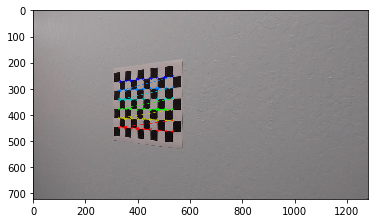

In [2]:
%matplotlib inline

# Find chessboard corners
def FindChessboardCorners(img, nx = 9, ny = 6):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)   
    return ret, corners

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

def EvaluateObjImgPts(camera_images, nx = 9, ny = 6):
    random = np.random.randint(20, size=1)
    random_idx = random[0]
    for idx, fname in enumerate(camera_images):
        img = cv2.imread(fname)
        
        ret, corners = FindChessboardCorners(img)
        
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            if random_idx == idx :
                plt.imshow(img)
    plt.show()  
    
# Make a list of calibration images
camera_images = glob.glob('camera_cal/calibration*.jpg')
EvaluateObjImgPts(camera_images)
    


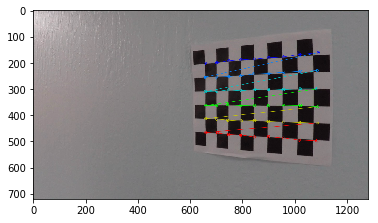

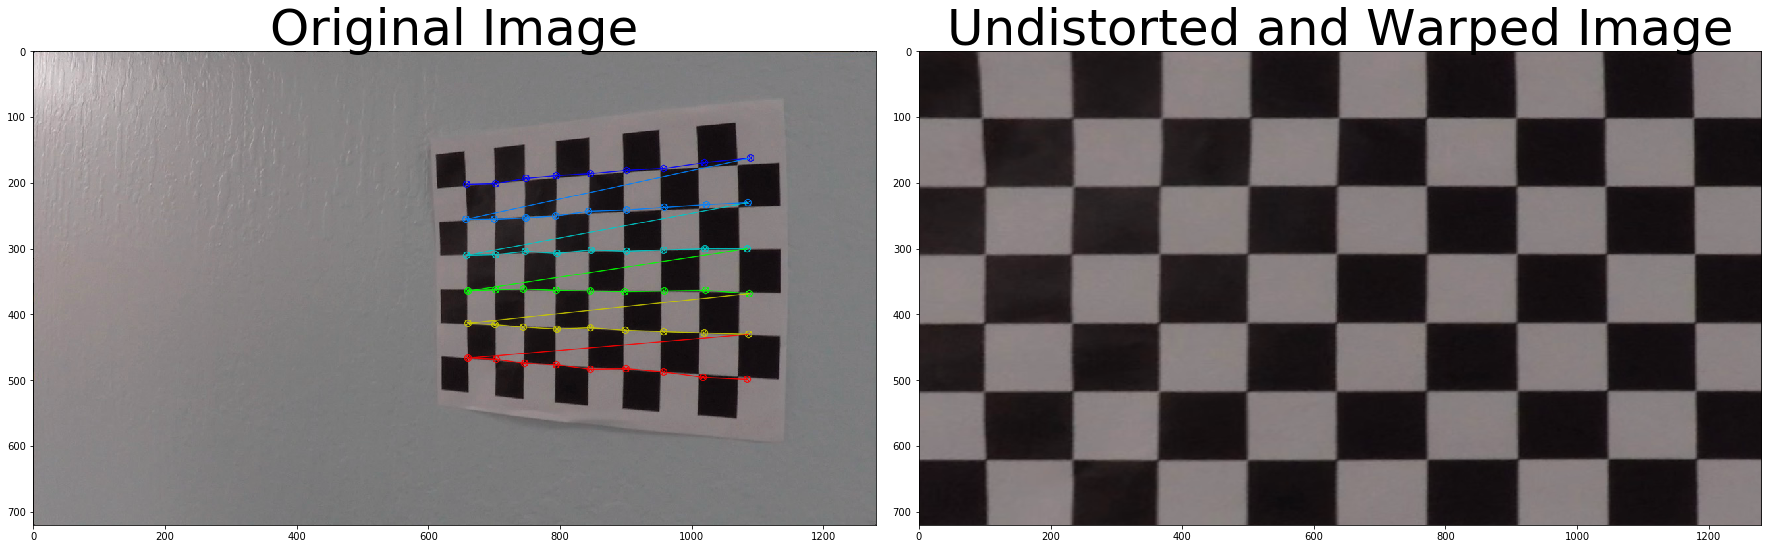

In [3]:
%matplotlib inline

# camera calibration (test undistortion on a test image)
def CalibrateUnwarp(img, nx = 9, ny = 6):
    img_size = (img.shape[1], img.shape[0])

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    
    # 2) Convert to grayscale
    gray_img = cv2.cvtColor(undist_img, cv2.COLOR_BGR2GRAY)
    
    # 3) Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray_img, (nx, ny), None)

    # 4) If corners found: 
    warped = img
    M = []
    if ret == True:
        # a) draw corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.imshow(img)
            
        # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
                         
        #Note: you could pick any four of the detected corners 
        # as long as those four corners define a rectangle
        #One especially smart way to do this would be to use four well-chosen
        # corners that were automatically detected during the undistortion steps
        #We recommend using the automatic detection of corners in your code
        
        # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
        offset = 100
        img_size = (gray_img.shape[1], gray_img.shape[0])
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        
        # e) use cv2.warpPerspective() to warp your image to a top-down view
        warped = cv2.warpPerspective(undist_img, M, img_size)

    return mtx, dist, warped, M
    
img = cv2.imread(camera_images[3])
camera_calib, dist, top_down, perspective_M = CalibrateUnwarp(img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

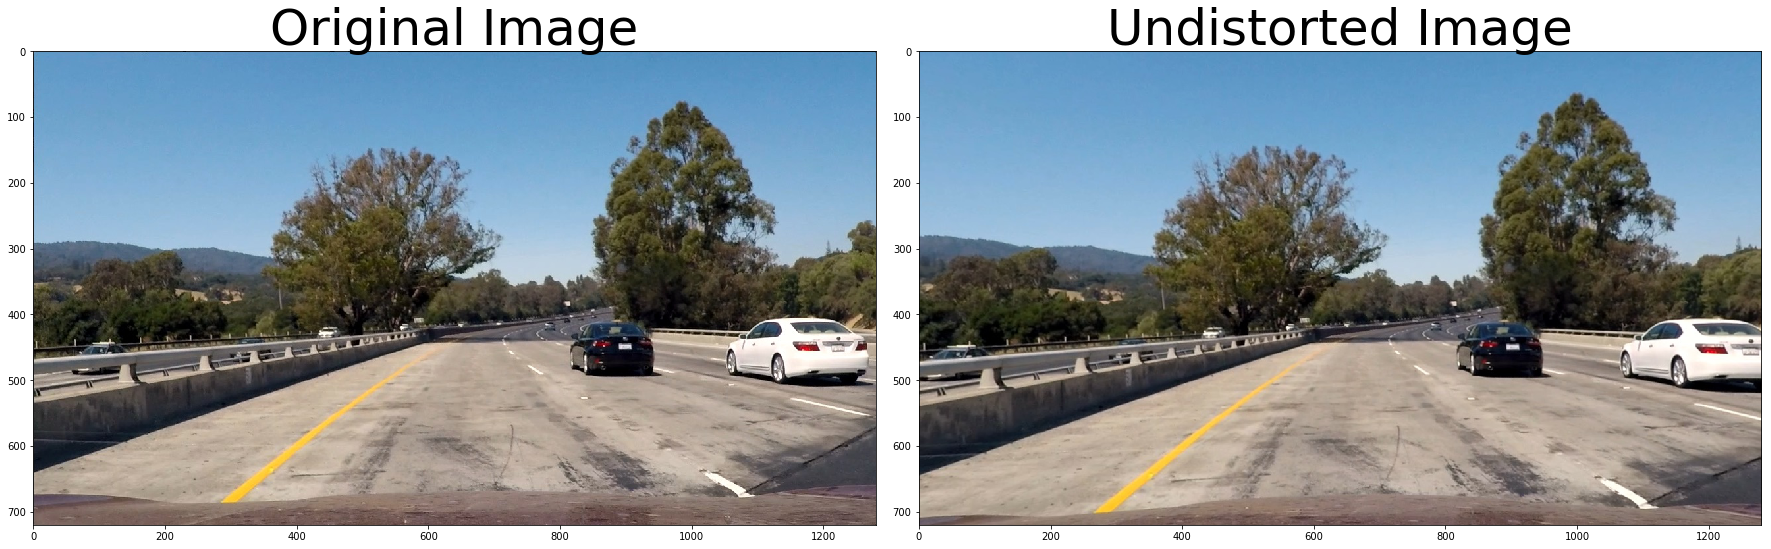

In [4]:
# Undistort test images
def UndistortImage(img, mtx = camera_calib, distortion = dist):
    img_size = (img.shape[1], img.shape[0])
    undist_img = cv2.undistort(img, mtx, distortion, None, mtx)    
    return undist_img

test_images = glob.glob('test_images/*.jpg')

img = cv2.imread(test_images[2])
proc_img = UndistortImage(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(cv2.cvtColor(proc_img, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [5]:
# apply threshold and possibly crop non-lane regions

# Edit this function to create your own pipeline.
def Threshold(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]

    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    combined = np.zeros_like(s_channel)
    combined[(s_binary == 1) | (sxbinary == 1)] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    # color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    color_binary = np.dstack((combined,combined,combined))
    return color_binary



In [6]:
# Extracts a ROI

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (1,) * channel_count
    else:
        ignore_mask_color = 1
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

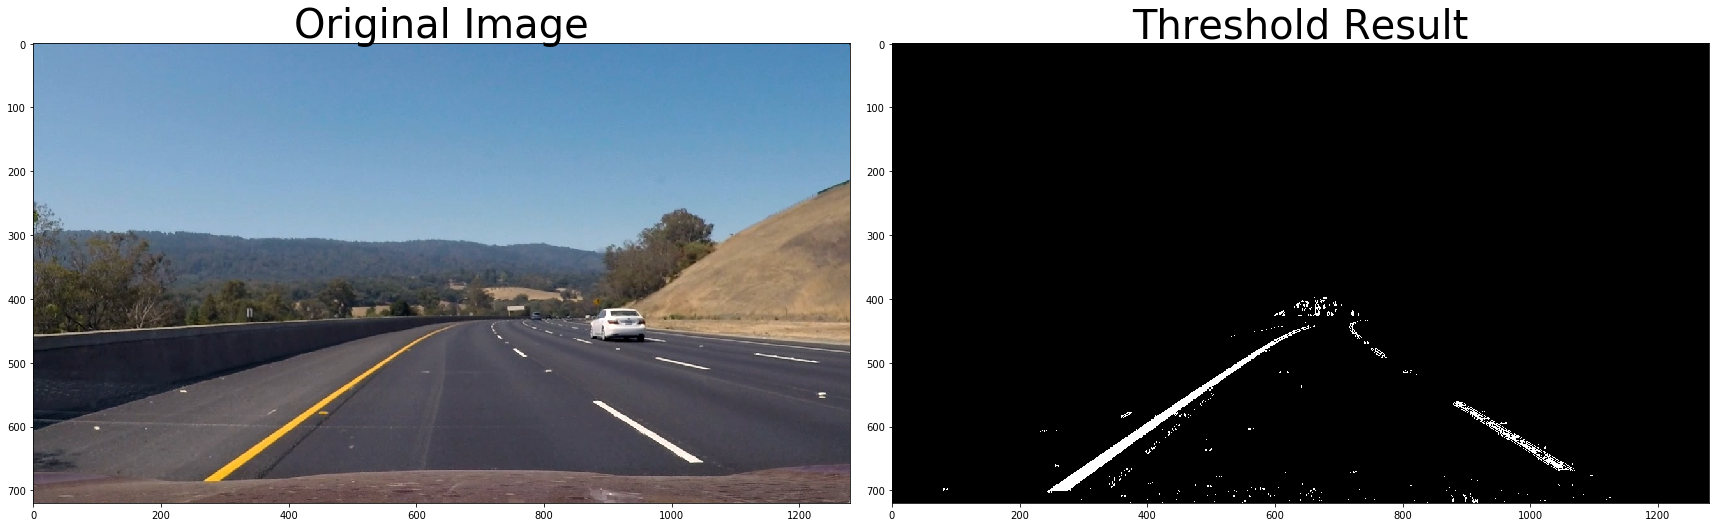

In [9]:
def FinalProcImage(img):
    proc_img = UndistortImage(img)
    th_image = Threshold(proc_img)

    apex = [30 + 0.5*img.shape[1], 30 + 0.5*img.shape[0]]
    vertices = np.array([[(0, img.shape[0]), (img.shape[1], img.shape[0]), 
                          (apex[0], apex[1])]], dtype=np.int32)
    masked_th_image = region_of_interest(th_image,vertices)
    return masked_th_image

img = cv2.imread(test_images[4])
masked_th_image = FinalProcImage(img)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(masked_th_image)
ax2.set_title('Threshold Result', fontsize=40)